#Section 1: Dataset

I’ve chosen to use the SMS Spam Collection dataset provided by UCI Machine Learning* for this project, which aims to predict whether an SMS message is spam or not. This is done by applying NLP systems to the dataset, and evaluating each system applied. This dataset contains a collection of spam and non-spam (ham) messages collated from a number of different sources:
425 SMS spam messages taken from the Grumbletext website, a UK forum for community reported spam messages
3,375 SMS ham messages taken from NUS SMS Corpus, a dataset that collected real messages from volunteers
450 SMS ham messages from Caroline Tag’s PhD thesis
1,002 ham and 322 spam messages from SMS Spam Corpus V.0.1 Big, a publicly available spam/ham dataset.
The contents of the dataset is very simple, it comes in a basic text file, where every line is an instance, the first word of each line is the class, followed by the message. This should make pre-processing a very simple job.
NLP systems are useful to achieve the project aim because of how effective they can be at predicting the class based on training. Furthermore, doing this may prove useful in real world scenarios for preventing potentially harmful spam messages from reaching users.

*https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [1]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 39.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import io
from google.colab import files

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import pandas as pd

import string
import re

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

np.random.seed(1337)

In [3]:
# Dataset Link: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

raw = files.upload()
test_file = io.BytesIO(raw['SMSSpamCollection'])
dataset = np.loadtxt(test_file, dtype="str", delimiter="\t")
print(dataset)


Saving SMSSpamCollection to SMSSpamCollection
[['ham'
  'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...']
 ['ham' 'Ok lar... Joking wif u oni...']
 ['spam'
  "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]
 ...
 ['ham' 'Pity, * was in mood for that. So...any other suggestions?']
 ['ham'
  "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free"]
 ['ham' 'Rofl. Its true to its name']]


In [4]:
print(dataset.shape)

(5574, 2)


In [5]:
y,x = dataset.T


#print("Pre-Oversampling:")
#print("Occurences of 'ham' messages: ", Counter(y)['ham'])
#print("Occurences of 'spam' messages: ", Counter(y)['spam'])

print(x)
#oversample = RandomOverSampler(sampling_strategy='minority')
#x,y = oversample.fit_resample(x,y)

#print("\nPost-Oversampling:")
#print("Occurences of 'ham' messages: ", Counter(y)['ham'])
#print("Occurences of 'spam' messages: ", Counter(y)['spam'])




['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'
 'Ok lar... Joking wif u oni...'
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
 ... 'Pity, * was in mood for that. So...any other suggestions?'
 "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free"
 'Rofl. Its true to its name']


In [6]:
#Credit: Yann Dubois on Stack Overflow - https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    # replacing text slang, Craig work
    phrase = re.sub(r"\bu\b", "you", phrase)
    phrase = re.sub(r"\br\b", "are", phrase)
    phrase = re.sub(r"\bc\b", "see", phrase)
    phrase = re.sub(r"\bk\b", "okay", phrase)
    phrase = re.sub(r"\bcoz\b", "because", phrase)
    phrase = re.sub(r"\bthx\b", "thanks", phrase)
    phrase = re.sub(r"\bgr8\b", "great", phrase)
    phrase = re.sub(r"\bb\b", "be", phrase)
    phrase = re.sub(r"\bur\b", "your", phrase)
    phrase = re.sub(r"\bpls\b", "please", phrase)

    # replacing digits with text-ified version

    phrase = re.sub(r"£", "pounds ", phrase)
    phrase = re.sub(r"1", "one ", phrase)
    phrase = re.sub(r"2", "two ", phrase)
    phrase = re.sub(r"3", "three ", phrase)
    phrase = re.sub(r"4", "four ", phrase)
    phrase = re.sub(r"5", "five ", phrase)
    phrase = re.sub(r"6", "six ", phrase)
    phrase = re.sub(r"7", "seven ", phrase)
    phrase = re.sub(r"8", "eight ", phrase)
    phrase = re.sub(r"9", "nine ", phrase)
    phrase = re.sub(r"0", "zero ", phrase)



    return phrase

# Tokenization
tokenizedData = []
for row in x:
  #for word in row:
    normal = decontracted(row.lower())
    normal = normal.translate(str.maketrans('', '', string.punctuation))
    splitRow = normal.split()
    tokenizedData.append(splitRow)




In [7]:
#Stop Word Removal / Stemming
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('english'))

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
normalizedData = []

for row in tokenizedData:
  swr_text = [stemmer.stem(token) for token in row if token not in stopwords.words('english')]
  #swr_text = np.array(swr_text)

  normalizedData.append(swr_text)

print(normalizedData)

[['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat'], ['ok', 'lar', 'joke', 'wif', 'oni'], ['free', 'entri', 'two', 'wkli', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'two', 'one', 'st', 'may', 'two', 'zero', 'zero', 'five', 'text', 'fa', 'eight', 'seven', 'one', 'two', 'one', 'receiv', 'entri', 'questionstd', 'txt', 'ratetse', 'appli', 'zero', 'eight', 'four', 'five', 'two', 'eight', 'one', 'zero', 'zero', 'seven', 'five', 'overon', 'eight'], ['dun', 'say', 'earli', 'hor', 'see', 'alreadi', 'say'], ['nah', 'think', 'goe', 'usf', 'live', 'around', 'though'], ['freemsg', 'hey', 'darl', 'three', 'week', 'word', 'back', 'would', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'âpound', 'one', 'five', 'zero', 'rcv'], ['even', 'brother', 'like', 'speak', 'treat', 'like', 'aid', 'patent'], ['per', 'request', 'amell', 'mell', 'oru', 'minnaminungint', 'nurungu', 'vettam', 'set', 'callertun', 'caller',

#Section 2: Representation Learning

Once the data is loaded in and preprocessed, representation learning needs to be applied to the text data, to convert it to a representation suitable for using with algorithms. Because of the content of the dataset, which is made up of relatively short sentences, with a more unique vocabulary, I’ve chosen to use Word2Vec. This technique creates vector representation of words, based on the surrounding words, which allows the algorithm to capture semantic information about words, and predict a word based on its neighbours (CBOW), or predict neighbours based on a word (Skip-Gram). Under the surface, this work is done by a relatively shallow neural network, utilizing a softmax function and backpropagation to iteratively train x weights. This produces a vector with x dimensions for each word passed to the embedder, where x is the vector size chosen by the user.
Machine learning algorithms desire inputs of fixed lengths and the dataset sentences are of variable length. To work around this, we first train our Word2Vec model on our entire dataset. Then we loop through each sentence; for each word in the sentence we get a pretrained vector from Word2Vec. Then we get an average vector based on the vectors in the sentence. This results in an array of fixed length vectors that represent each sentence in the dataset.


In [9]:
# Text Representation - using word2vec
w2v_model = Word2Vec(vector_size=300, window=5, min_count=1, workers=4) #we parametrise our model - size is the output size, window the size of our sliding window, min_count is the number of times a word must appear to be considered, workers is number of threads
w2v_model.build_vocab(normalizedData, update=None) #we then build our vocabulary. This step basically performs a single runthrough of the text to identify all unique words
w2v_model.train(corpus_iterable=normalizedData, total_examples=len(normalizedData), epochs=50) #finally we train the model. We set our input as the tokenized text, we state the number of examples in our dataset and the number of epochs to train for




(2364469, 2934750)

In [14]:
acc_score = []

def word2vec_rep(sentence, w2v_model):
  embs = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv.index_to_key]
  if len(embs) == 0:
    # Return a zero vector of the correct dimension if no words found
    return np.zeros(w2v_model.vector_size)

  else:
    sent_emb = np.mean(np.array(embs), axis=0)
    return sent_emb

prep_x = np.array([word2vec_rep(doc, w2v_model) for doc in normalizedData])
print(prep_x[0])

[-0.09493642 -0.11341543 -0.0104512   0.18308674 -0.00309794 -0.08206543
  0.08353279  0.45200127  0.05478366 -0.19630025  0.14792797  0.21595941
  0.12603366 -0.13523455 -0.16528432 -0.13209558  0.14938411  0.22697562
  0.13827203  0.15376043  0.01906096 -0.11640837  0.11456082 -0.0506486
  0.2332397   0.04481064 -0.16534367  0.13958599  0.00935297 -0.29596063
  0.05730186  0.01154589 -0.10910641  0.0455498  -0.12305544  0.12586601
  0.24312463 -0.38439476 -0.20475613 -0.06039017 -0.09691947  0.12039489
 -0.03114504 -0.14942858  0.10316142  0.24755302  0.2666668   0.09781147
  0.11477453 -0.14394896  0.07090642  0.1552316  -0.13583234 -0.02309246
  0.11229312  0.0659445   0.22720315  0.12963779  0.11184791 -0.07936012
 -0.10650936 -0.2413432   0.18348803  0.1367052   0.14685264  0.2061324
 -0.09815256 -0.16563222 -0.11538013 -0.17083697  0.09895016  0.32437444
 -0.00341793 -0.43651694  0.33644667 -0.07822075 -0.30272561  0.05696774
 -0.21489929  0.43637103 -0.21957667 -0.25621942  0.0

#Section 3: Algorithms

##k-Nearest Neighbours
kNN is a relatively simple algorithm, that works by comparing new data to historic data, and making assumptions based on the labels of those closest to the new data. Essentially we can break the process down into 3 steps:
First we calculate the distance between the historical data and the new query
Then we order the data based on distance
Then we extract the top ‘k’ instances, which are used to determine the label of the new data.
For classification tasks, this means labelling the new query to match the majority of selected neighbours, whereas for regression tasks the average of those neighbouring labels is used. Parameters of the algorithm can be changed to finetune results, the most common choices being the number of neighbours to be considered when querying, the metric used to calculate distance between data, and the weighting that neighbouring points have when making predictions. I chose to use kNN for this task, as it’s well suited for simple classification problems, and fairly easy to tune the parameters for.


##Logistic Regression
Logistic regression is a binary classification model that predicts the probability that a data sample belongs to a class. Our multi-linear function takes the form z=Σ(wᵢxᵢ) + b where w is our weight and b is our bias. We then apply a sigmoid function to this, which bounds our value between 0 and 1, our probability. Using a threshold value, which is usually 0.5, we can predict a class from this. Like kNN, logistic regression has a number of variables that can be tweaked to improve performance. However, I found it more difficult to finetune parameters as some are dependent on others. For example, the solver algorithm only works with select penalty variables, and choosing an incompatible combination will choose the code to crash. That aside, I chose to use logistic regression because it should perform well on binary classification tasks.


---


We can improve further on these 2 classifiers by using oversampling, gridSearch and stratified k-fold cross validation. Oversampling allows us to create a more balanced dataset, by randomly duplicating instances from classes that make up a minority of the data. In our case, we have a lot less spam messages, so we oversample the spam class, so that our dataset contains an equal balance of spam and ham data.
GridSearch allows us to easily tweak parameters, by providing our classifiers with a list of parameters, and the values we want to try for each parameter. When running, our classifier will then perform with every combination of our chosen parameter, and record the combination that provided the best accuracy.
K-fold cross validation is a technique that breaks the data into subsets to iteratively train and test on, avoiding situations where a label class is fully in the test set, and not present in the training set - leading to overfitting. Stratified K-Fold cross validation is an enhancement of this technique as it also accounts for imbalanced datasets by ensuring the label ratio stays the same as the original dataset in every subset. This is useful for keeping the label ratio of the test set.



In [11]:
kf = StratifiedKFold(n_splits=5)

knn_overall_y_pred = []
knn_overall_y_test = []
curKf = 0

knn_Acc = []
for train, test in kf.split(x,y):
  print("K-Fold Number: ", curKf)
  x_train, x_test, y_train, y_test = prep_x[train], prep_x[test], y[train], y[test]
  print("Pre-Oversampling:")
  print("Occurences of train 'ham' messages: ", Counter(y_train)['ham'])
  print("Occurences of train 'spam' messages: ", Counter(y_train)['spam'])

  oversample = RandomOverSampler(sampling_strategy='minority')
  x_train_oversampled, y_train_oversampled = oversample.fit_resample(x_train, y_train)

  print("\nPost-Oversampling:")
  print("Occurences of train 'ham' messages: ", Counter(y_train_oversampled)['ham'])
  print("Occurences of train 'spam' messages: ", Counter(y_train_oversampled)['spam'])

  kNN = KNeighborsClassifier()
  parameters = {"n_neighbors":[3,5,10,20], "weights":["distance", "uniform"], "metric":["euclidean", "cosine"]}

  gridSearch_Knn = GridSearchCV(kNN, parameters)
  gridSearch_Knn.fit(x_train_oversampled, y_train_oversampled)


  #kNN.fit(x_train_oversampled, y_train_oversampled)

  #y_pred = kNN.predict(x_test)
  y_pred = gridSearch_Knn.predict(x_test)

  print("\n")

  acc = gridSearch_Knn.best_score_
  #f1 = f1_score(y_pred, y_test, average='weighted')
  #print("K-Fold ", curKf," F1 score: ", f1)
  print("K-Fold ", curKf," Top Accuracy: ",acc)
  print("K-Fold ", curKf," GridSearch Top Parameters: ", gridSearch_Knn.best_params_)

  print("\n")
  knn_overall_y_pred.extend(y_pred)
  knn_overall_y_test.extend(y_test)
  knn_Acc.append(acc)

  curKf+=1

print("Average Accuracy:", np.mean(knn_Acc))



K-Fold Number:  0
Pre-Oversampling:
Occurences of train 'ham' messages:  3861
Occurences of train 'spam' messages:  598

Post-Oversampling:
Occurences of train 'ham' messages:  3861
Occurences of train 'spam' messages:  3861


K-Fold  0  Top Accuracy:  0.9839422673843419
K-Fold  0  GridSearch Top Parameters:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


K-Fold Number:  1
Pre-Oversampling:
Occurences of train 'ham' messages:  3861
Occurences of train 'spam' messages:  598

Post-Oversampling:
Occurences of train 'ham' messages:  3861
Occurences of train 'spam' messages:  3861


K-Fold  1  Top Accuracy:  0.9827773026812213
K-Fold  1  GridSearch Top Parameters:  {'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}


K-Fold Number:  2
Pre-Oversampling:
Occurences of train 'ham' messages:  3862
Occurences of train 'spam' messages:  597

Post-Oversampling:
Occurences of train 'ham' messages:  3862
Occurences of train 'spam' messages:  3862


K-Fold  2  Top Accur

In [12]:
#Add gridSearch

overall_y_pred = []
overall_y_test = []

kfoldCount=[]
curLogReg = 0

logReg_overall_y_pred = []
logReg_overall_y_test = []

logReg_Acc = []

kf = StratifiedKFold(n_splits=5)

#"penalty": ["none", "l1", "l2", "elasticnet"], "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
for train, test in kf.split(x,y):
  x_train, x_test, y_train, y_test = prep_x[train], prep_x[test], y[train], y[test]
  #print("Pre-Oversampling:")
  #print("Occurences of train 'ham' messages: ", Counter(y_train)['ham'])
  #print("Occurences of train 'spam' messages: ", Counter(y_train)['spam'])


  oversample = RandomOverSampler(sampling_strategy='minority')
  x_train_oversampled, y_train_oversampled = oversample.fit_resample(x_train, y_train)

  logReg = LogisticRegression()
  parameters = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

  gridSearch_LogReg = GridSearchCV(logReg, parameters)

  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridSearch_LogReg.fit(x_train_oversampled, y_train_oversampled)

  y_pred = gridSearch_LogReg.predict(x_test)

  #logReg_Acc.append(accuracy_score(y_test, y_pred))
  overall_y_pred.extend(y_pred)
  overall_y_test.extend(y_test)

  acc = gridSearch_LogReg.best_score_
  logReg_Acc.append(acc)

  #kfoldCount.append(curSplit)
  #curSplit+=1

  logReg_overall_y_pred.extend(y_pred)
  logReg_overall_y_test.extend(y_test)

  #print(len(overall_y_pred))

  print("K-Fold ", curLogReg," Top Accuracy: ",acc)
  print("K-Fold ", curLogReg," GridSearch Top Parameters: ", gridSearch_LogReg.best_params_)


  curLogReg += 1
print("Average Accuracy:", np.mean(logReg_Acc))

#plot_confusionMatrix(overall_y_test,overall_y_pred)
# plt.plot(kfoldCount, logReg_Acc)
# plt.xlabel('K-Fold Split')
# plt.ylabel('Accuracy')
# plt.show()


K-Fold  0  Top Accuracy:  0.9713789258346328
K-Fold  0  GridSearch Top Parameters:  {'C': 1, 'penalty': 'l2'}
K-Fold  1  Top Accuracy:  0.9720276841558093
K-Fold  1  GridSearch Top Parameters:  {'C': 10, 'penalty': 'l2'}
K-Fold  2  Top Accuracy:  0.9769544074987004
K-Fold  2  GridSearch Top Parameters:  {'C': 10, 'penalty': 'l2'}
K-Fold  3  Top Accuracy:  0.9715166758891293
K-Fold  3  GridSearch Top Parameters:  {'C': 1000, 'penalty': 'l2'}
K-Fold  4  Top Accuracy:  0.9735892147492329
K-Fold  4  GridSearch Top Parameters:  {'C': 10, 'penalty': 'l2'}
Average Accuracy: 0.9730933816255009


##Section 4: Evaluation
In order to perform a solid evaluation of the models, we need to keep track of multiple variables along the way. Our initial outcome, overall accuracy - which I've used primarily as the classes are balanced, shows the slightest variation between the two models: kNN sits at around 98% accuracy, while logistic regression sits at around 97%. These high accuracies can be attributed to the simplicity of the dataset, and the preprocessing performed. Next, we can use the predicted and correct results of the classifiers to plot a confusions matrix, to analyse where the classifiers went wrong. From this, we can see that kNN generally has slightly more false positives in the misclassified data (84% false positives, 16% false negatives), while logistic regression generates slightly more false negatives (80% false positives, 20% false negatives). This could be due to threshold value of logistic regression, which I’d play with if I had time. Finally we can visualise a boxplot of the average accuracies for each fold. From this we can see a wider spread of accuracies present in logistic regression, that’s not mirrored in kNN, which has a much tighter distribution - leading me to believe that kNN is the superior algorithm for this task. If I had more time I’d like to investigate the accuracy spread of logistic regression, and analyse other scoring methods like f1 score.


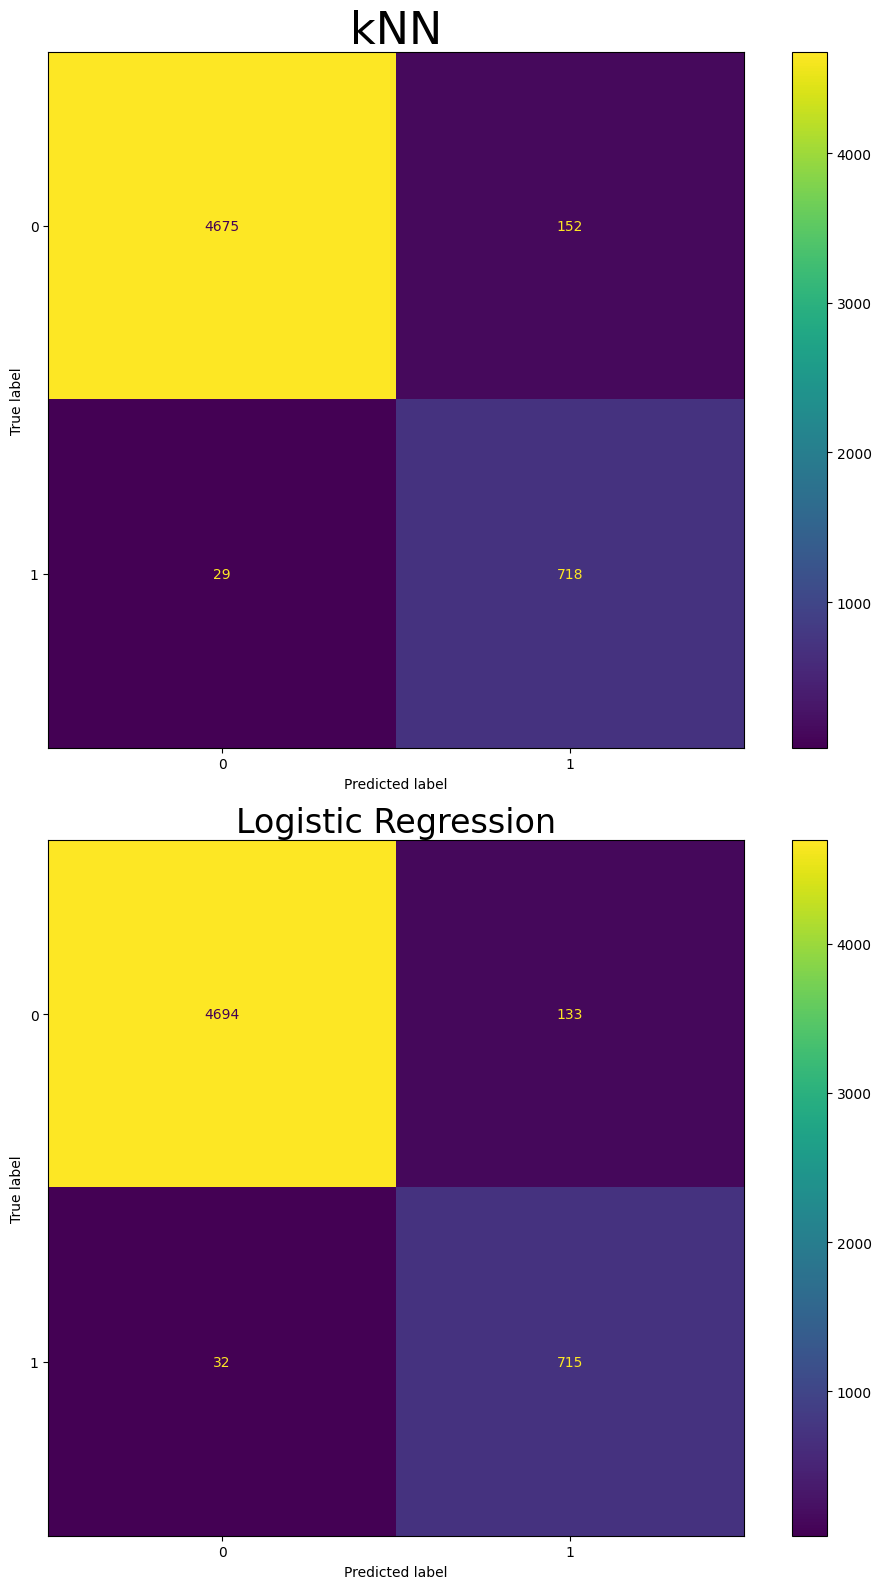

In [ ]:


f, axes = plt.subplots(2, 1, figsize=(10, 16))

cm_knn = confusion_matrix(y_true=knn_overall_y_test,y_pred=knn_overall_y_pred, )
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot(include_values=True, ax=axes[0])
axes[0].set_title("kNN", size=32)

cm_logReg = confusion_matrix(y_true=logReg_overall_y_test,y_pred=logReg_overall_y_pred, )
ConfusionMatrixDisplay(confusion_matrix=cm_logReg).plot(include_values=True, ax=axes[1], colorbar=True)
axes[1].set_title("Logistic Regression", size=24)


f.tight_layout()
#plt.subplot(1, 2, 1)
#plt.subplot(disp)

[Text(1, 0, 'kNN'), Text(2, 0, 'Logistic Regression')]

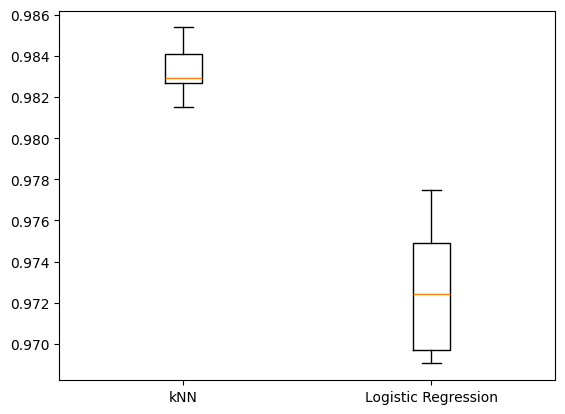

In [ ]:
plt.boxplot([knn_Acc, logReg_Acc])
ax = plt.gca()
ax.set_xticklabels(['kNN', 'Logistic Regression'])
